# Black Garlic CNN Modellingh via Transfer Learning

In [2]:
import tensorflow as tf
print(tf.keras.__version__)

3.4.1


In [3]:
physical_devices = tf.config.list_physical_devices('XPU')
physical_devices

[PhysicalDevice(name='/physical_device:XPU:0', device_type='XPU')]

## Data Preparation

In [5]:
#Prep the notebook
#import necessary sources 
import tensorflow as tf
import keras
import matplotlib.pyplot as plt
import pandas as pd
from keras import layers
from helper_functions import create_tensorboard_callback, plot_loss_curves, unzip_data, walk_through_dir, make_confusion_matrix, compare_historys
from sklearn.metrics import accuracy_score


#inspect the dataset directory
walk_through_dir("black_garlic_main")

# Create training, validation and test directories
train_dir = "black_garlic_main/train/"
test_dir = "black_garlic_main/test/"
val_dir = "black_garlic_main/val/"

# Create data inputs
IMG_SIZE = (224, 224) # define image size
train_data = keras.utils.image_dataset_from_directory(directory=train_dir,
                                                      image_size=IMG_SIZE,
                                                      label_mode="categorical",
                                                      batch_size=32)
test_data = keras.utils.image_dataset_from_directory(directory=test_dir,
                                                     image_size=IMG_SIZE,
                                                     label_mode="categorical",
                                                     batch_size=32,
                                                     shuffle=False)
val_data = keras.utils.image_dataset_from_directory(directory=val_dir,
                                                    image_size=IMG_SIZE,
                                                    batch_size=32,
                                                    label_mode="categorical",
                                                    shuffle=True)


There are 3 directories and 0 images in 'black_garlic_main'.
There are 3 directories and 0 images in 'black_garlic_main/train'.
There are 0 directories and 370 images in 'black_garlic_main/train/underaged'.
There are 0 directories and 370 images in 'black_garlic_main/train/overaged'.
There are 0 directories and 370 images in 'black_garlic_main/train/excellent'.
There are 3 directories and 0 images in 'black_garlic_main/test'.
There are 0 directories and 20 images in 'black_garlic_main/test/underaged'.
There are 0 directories and 20 images in 'black_garlic_main/test/overaged'.
There are 0 directories and 20 images in 'black_garlic_main/test/excellent'.
There are 3 directories and 0 images in 'black_garlic_main/val'.
There are 0 directories and 65 images in 'black_garlic_main/val/underaged'.
There are 0 directories and 65 images in 'black_garlic_main/val/overaged'.
There are 0 directories and 65 images in 'black_garlic_main/val/excellent'.
Found 1110 files belonging to 3 classes.
Found 6

## Add functions

In [4]:
#Script to generate important details and figures
res = []
def generate_details(model,test_data,history,tuned=False):
    print("Evaluating...")
    loaded_loss, loaded_accuracy = model.evaluate(test_data)
    loaded_loss, loaded_accuracy
    print("done.")
    #make predictions usind the model
    print("Predicting...")
    pred_probs = model.predict(test_data, verbose=1) # set verbosity to see how long it will take
    print("done.")

    #save the evaluation results for tabulation
    res.append([model.name,round(loaded_loss*100,4),round(loaded_accuracy*100,4)])
    
    # Get the class predicitons of each label
    pred_classes = pred_probs.argmax(axis=1)
    
    # How do they look?
    pred_classes[:10]
    
    # make labels using unbatch
    y_labels = []
    for images, labels in test_data.unbatch(): # unbatch the test data and get images and labels
      y_labels.append(labels.numpy().argmax()) # append the index which has the largest value (labels are one-hot)
    y_labels[:10] # check what they look like (unshuffled)
    
    # Get accuracy score by comparing predicted classes to ground truth labels
    sklearn_accuracy = accuracy_score(y_labels, pred_classes)
    sklearn_accuracy
    
    # Does the evaluate method compare to the Scikit-Learn measured accuracy?
    import numpy as np
    print(f"Close? {np.isclose(loaded_accuracy, sklearn_accuracy)} | Difference: {loaded_accuracy - sklearn_accuracy}")
    
    # Get the class names
    class_names = test_data.class_names
    class_names[:10]
    
    #Genrate the confusion matrix
    make_confusion_matrix(y_true=y_labels,
                          y_pred=pred_classes,
                          classes=class_names,
                          figsize=(5, 5),
                          text_size=10,
                          norm=True,#with percentage
                          savefig=True,
                          name=model.name)
    if tuned:
        #plot hystorys
        compare_historys(original_history=history[0],
                         new_history=history[1],
                         initial_epochs=history[2])
    else:
        #Plot the curves
        plot_loss_curves(history[0],figsize=(6, 3))


# Setup checkpoint path
def setup_checkpoint(model_name):
    weights_checkpoint_path = "checkpoints/"+model_name+".weights.h5"
    model_checkpoint_path = "checkpoints/"+model_name+"model.keras" 
    
    # Create a ModelCheckpoint callback that saves the model's weights only
    weights_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(filepath=weights_checkpoint_path,
                                                             save_weights_only=True, # set to False to save the entire model
                                                             save_best_only=True, # save only the best model weights instead of a model every epoch
                                                             save_freq="epoch", # save every epoch
                                                             verbose=1)
    
    # Create a ModelCheckpoint callback that saves the whole model
    model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(filepath=model_checkpoint_path,
                                                             save_best_only=True, # save only the best model weights instead of a model every epoch
                                                             save_freq="epoch", # save every epoch
                                                             verbose=1)
    
    return (weights_checkpoint_callback, weights_checkpoint_path)

#results printer
def show_results(results):
    all_results = pd.DataFrame(results, columns=["Model", "Loss", "Accuracy"])
    return all_results

# Model 1 EfficientNetB0

In [5]:
base_model = tf.keras.applications.EfficientNetB0(include_top=False)
base_model.trainable = False
inputs = tf.keras.layers.Input(shape=(224, 224, 3), name="input_layer")
x = base_model(inputs)
x = tf.keras.layers.GlobalAveragePooling2D(name="global_average_pooling_layer")(x)
outputs = tf.keras.layers.Dense(3, activation="softmax", name="output_layer")(x)
model_1 = tf.keras.Model(inputs, outputs)
model_1.compile(loss='categorical_crossentropy',
              optimizer=tf.keras.optimizers.Adam(),
              metrics=["accuracy"],
              jit_compile = False)
              
model_1.name="Model_1_EfficientNetB0"

(checkpoint_callback,checkpoint_path)=setup_checkpoint(model_1.name)

history1 = model_1.fit(train_data,
                       epochs=10,
                       validation_data=val_data,
                       callbacks=[checkpoint_callback]
                      )

Epoch 1/10


2024-07-03 16:32:29.244295: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type XPU is enabled.


35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 204ms/step - accuracy: 0.4118 - loss: 1.0963
Epoch 1: val_loss improved from inf to 0.68109, saving model to checkpoints/Model_1_EfficientNetB0.weights.h5
35/35 ━━━━━━━━━━━━━━━━━━━━ 20s 308ms/step - accuracy: 0.4156 - loss: 1.0926 - val_accuracy: 0.8256 - val_loss: 0.6811
Epoch 2/10
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 170ms/step - accuracy: 0.7938 - loss: 0.6666
Epoch 2: val_loss improved from 0.68109 to 0.47395, saving model to checkpoints/Model_1_EfficientNetB0.weights.h5
35/35 ━━━━━━━━━━━━━━━━━━━━ 7s 205ms/step - accuracy: 0.7947 - loss: 0.6649 - val_accuracy: 0.8872 - val_loss: 0.4740
Epoch 3/10
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/step - accuracy: 0.8733 - loss: 0.4936
Epoch 3: val_loss improved from 0.47395 to 0.36436, saving model to checkpoints/Model_1_EfficientNetB0.weights.h5
35/35 ━━━━━━━━━━━━━━━━━━━━ 7s 208ms/step - accuracy: 0.8736 - loss: 0.4928 - val_accuracy: 0.9538 - val_loss: 0.3644
Epoch 4/10
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step - accuracy:

## results

Evaluating...
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 1.0000 - loss: 0.1475  
done.
Predicting...
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 1s/step
done.
Close? True | Difference: -5.960464477539063e-08


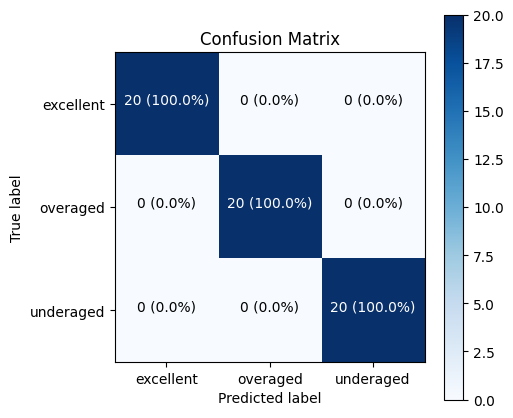

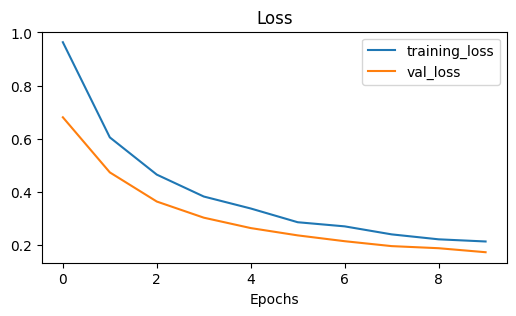

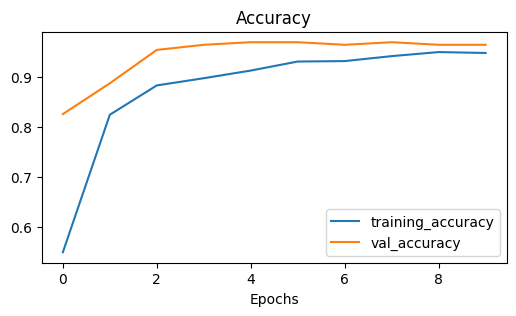

In [6]:
#Generate needed details
generate_details(model_1,test_data,[history1])

# Model 1 EfficientNetB0 with fine-tuning

In [7]:
model_1.load_weights(checkpoint_path)
model_1.layers[1].trainable = False

for layer in model_1.layers[1].layers[-10:]:
    if not isinstance(layer, layers.BatchNormalization):
            layer.trainable = True
    
model_1.compile(loss='categorical_crossentropy',
              optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), #set lower training rate
              metrics=["accuracy"],
              jit_compile = False)

initial_epochs = 10
fine_tune_epochs = initial_epochs + 10
model_1.name="Model_1_EfficientNetB0_with_fine-tuning"
(checkpoint_callback,checkpoint_path)=setup_checkpoint(model_1.name)

history1_tuned = model_1.fit(train_data,
                             epochs=fine_tune_epochs,
                             validation_data=val_data,
                             initial_epoch=history1.epoch[-1], 
                             callbacks=[checkpoint_callback]
                            )

Epoch 10/20
35/35 ━━━━━━━━━━━━━━━━━━━━ 15s 245ms/step - accuracy: 0.9174 - loss: 0.2484 - val_accuracy: 0.9744 - val_loss: 0.1037
Epoch 11/20
35/35 ━━━━━━━━━━━━━━━━━━━━ 7s 198ms/step - accuracy: 0.9696 - loss: 0.1175 - val_accuracy: 0.9641 - val_loss: 0.1024
Epoch 12/20
35/35 ━━━━━━━━━━━━━━━━━━━━ 7s 202ms/step - accuracy: 0.9752 - loss: 0.0942 - val_accuracy: 0.9846 - val_loss: 0.0716
Epoch 13/20
35/35 ━━━━━━━━━━━━━━━━━━━━ 7s 206ms/step - accuracy: 0.9694 - loss: 0.0864 - val_accuracy: 0.9744 - val_loss: 0.0774
Epoch 14/20
35/35 ━━━━━━━━━━━━━━━━━━━━ 7s 200ms/step - accuracy: 0.9833 - loss: 0.0610 - val_accuracy: 0.9846 - val_loss: 0.0558
Epoch 15/20
35/35 ━━━━━━━━━━━━━━━━━━━━ 7s 198ms/step - accuracy: 0.9854 - loss: 0.0580 - val_accuracy: 0.9846 - val_loss: 0.0576
Epoch 16/20
35/35 ━━━━━━━━━━━━━━━━━━━━ 7s 197ms/step - accuracy: 0.9778 - loss: 0.0676 - val_accuracy: 0.9692 - val_loss: 0.0651
Epoch 17/20
35/35 ━━━━━━━━━━━━━━━━━━━━ 7s 201ms/step - accuracy: 0.9928 - loss: 0.0430 - val_acc

## results

Evaluating...
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step - accuracy: 1.0000 - loss: 0.0214
done.
Predicting...
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 1s/step
done.
Close? True | Difference: -5.960464477539063e-08


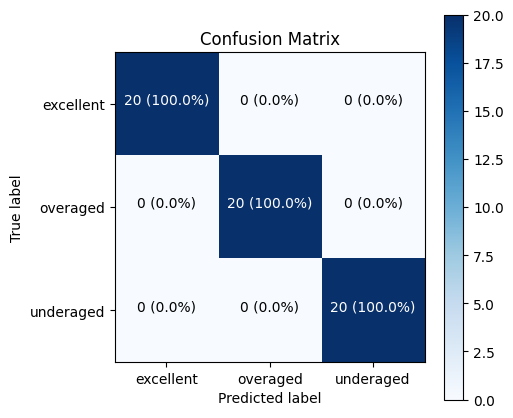

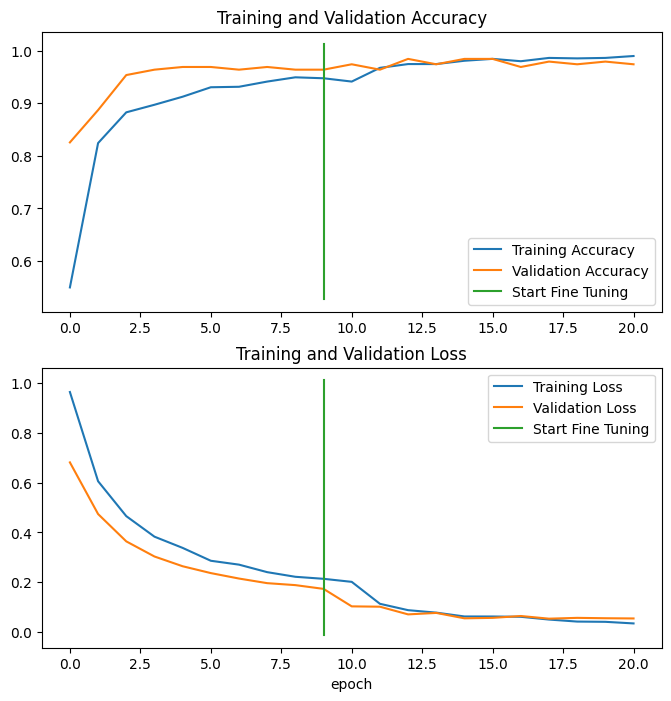

In [8]:
#Generate needed details
generate_details(model_1,test_data,[history1,history1_tuned,10],True)

# Model 2 EfficientNetB0 with augmentation

In [9]:
data_augmentation = keras.Sequential([
  layers.RandomZoom(0.1,0.3),
  layers.RandomFlip("horizontal"),
], name ="data_augmentation")

input_shape = (224, 224, 3)
base_model = tf.keras.applications.EfficientNetB0(include_top=False)
base_model.trainable = False
inputs = layers.Input(shape=input_shape, name="input_layer")
x = data_augmentation(inputs)
x = base_model(x, training=False)
x = layers.GlobalAveragePooling2D(name="global_average_pooling_layer")(x)
outputs = layers.Dense(3, activation="softmax", name="output_layer")(x)
model_2 = keras.Model(inputs, outputs)

model_2.compile(loss="categorical_crossentropy",
              optimizer=tf.keras.optimizers.Adam(),
              metrics=["accuracy"],
              jit_compile = False)

model_2.name="Model_2_EfficientNetB0_with_augmentation"

(checkpoint_callback,checkpoint_path)=setup_checkpoint(model_2.name)

history2 = model_2.fit(train_data,
                       epochs=10,
                       validation_data=val_data,
                       callbacks=[checkpoint_callback]
                      )

Epoch 1/10
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 181ms/step - accuracy: 0.3452 - loss: 1.1163
Epoch 1: val_loss improved from inf to 0.79381, saving model to checkpoints/Model_2_EfficientNetB0_with_augmentation.weights.h5
35/35 ━━━━━━━━━━━━━━━━━━━━ 16s 256ms/step - accuracy: 0.3495 - loss: 1.1127 - val_accuracy: 0.6615 - val_loss: 0.7938
Epoch 2/10
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 183ms/step - accuracy: 0.7418 - loss: 0.7445
Epoch 2: val_loss improved from 0.79381 to 0.60953, saving model to checkpoints/Model_2_EfficientNetB0_with_augmentation.weights.h5
35/35 ━━━━━━━━━━━━━━━━━━━━ 8s 219ms/step - accuracy: 0.7424 - loss: 0.7430 - val_accuracy: 0.7692 - val_loss: 0.6095
Epoch 3/10
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step - accuracy: 0.7917 - loss: 0.5961
Epoch 3: val_loss improved from 0.60953 to 0.48176, saving model to checkpoints/Model_2_EfficientNetB0_with_augmentation.weights.h5
35/35 ━━━━━━━━━━━━━━━━━━━━ 8s 214ms/step - accuracy: 0.7919 - loss: 0.5952 - val_accuracy: 0.8308 - val_loss: 0.481

## results

Evaluating...
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step - accuracy: 0.9562 - loss: 0.2047
done.
Predicting...
1/2 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/stepWARNING:tensorflow:6 out of the last 6 calls to <function TensorFlowTrainer.make_predict_function.<locals>.one_step_on_data_distributed at 0x7f6828739b80> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has reduce_retracing=True option that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/guide/function#controlling_retracing and https://www.tensorflow.org/api_docs/python/tf/function for  more details.
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 1s/step
done.
Close? True | Difference: -7.152557368605983e-08


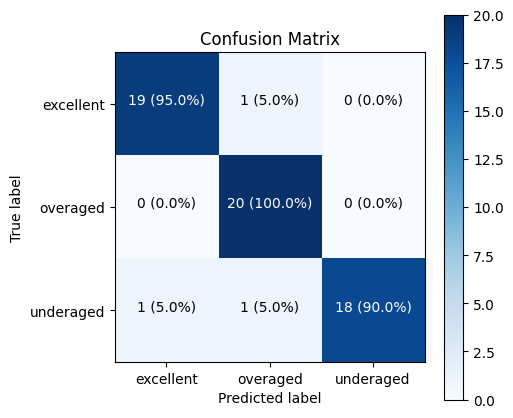

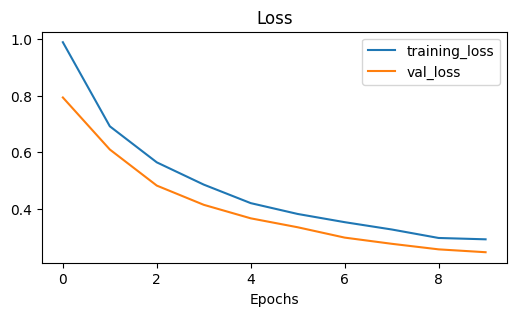

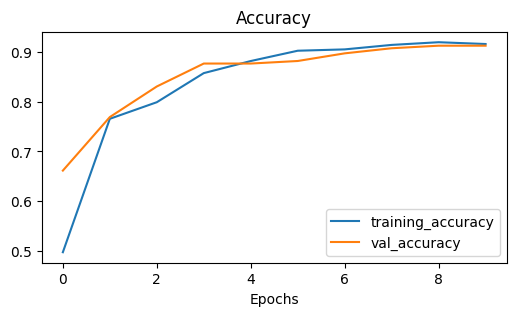

In [10]:
#Generate needed details
generate_details(model_2,test_data,[history2])

# Model 2 EfficientNetB0 with augmentation and fine-tuning

In [11]:
model_2.load_weights(checkpoint_path)
model_2.layers[2].trainable = False

for layer in model_2.layers[2].layers[-10:]:
    if not isinstance(layer, layers.BatchNormalization):
            layer.trainable = True

model_2.compile(loss='categorical_crossentropy',
              optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), #set lower training rate
              metrics=["accuracy"],
              jit_compile = False)

model_2.name = "Model_2_EfficientNetB0_with_augmentation_and_fine-tuning"
(checkpoint_callback,checkpoint_path)=setup_checkpoint(model_2.name)

initial_epochs = 10
fine_tune_epochs = initial_epochs + 10
history2_tuned = model_2.fit(train_data,
                             epochs=fine_tune_epochs,
                             validation_data=val_data,
                             initial_epoch=history2.epoch[-1],
                             callbacks=[checkpoint_callback]
                            )

Epoch 10/20
35/35 ━━━━━━━━━━━━━━━━━━━━ 16s 258ms/step - accuracy: 0.8863 - loss: 0.3255 - val_accuracy: 0.9436 - val_loss: 0.1695
Epoch 11/20
35/35 ━━━━━━━━━━━━━━━━━━━━ 8s 214ms/step - accuracy: 0.9568 - loss: 0.1531 - val_accuracy: 0.9436 - val_loss: 0.1350
Epoch 12/20
35/35 ━━━━━━━━━━━━━━━━━━━━ 8s 214ms/step - accuracy: 0.9585 - loss: 0.1217 - val_accuracy: 0.9487 - val_loss: 0.1202
Epoch 13/20
35/35 ━━━━━━━━━━━━━━━━━━━━ 8s 215ms/step - accuracy: 0.9581 - loss: 0.1277 - val_accuracy: 0.9333 - val_loss: 0.1430
Epoch 14/20
35/35 ━━━━━━━━━━━━━━━━━━━━ 8s 213ms/step - accuracy: 0.9751 - loss: 0.0863 - val_accuracy: 0.9333 - val_loss: 0.1436
Epoch 15/20
35/35 ━━━━━━━━━━━━━━━━━━━━ 8s 215ms/step - accuracy: 0.9706 - loss: 0.0774 - val_accuracy: 0.9487 - val_loss: 0.1098
Epoch 16/20
35/35 ━━━━━━━━━━━━━━━━━━━━ 8s 217ms/step - accuracy: 0.9742 - loss: 0.0830 - val_accuracy: 0.9590 - val_loss: 0.0974
Epoch 17/20
35/35 ━━━━━━━━━━━━━━━━━━━━ 8s 220ms/step - accuracy: 0.9794 - loss: 0.0622 - val_acc

## results

Evaluating...
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step - accuracy: 0.9569 - loss: 0.0880
done.
Predicting...
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 1s/step
done.
Close? True | Difference: -8.74201456779744e-08


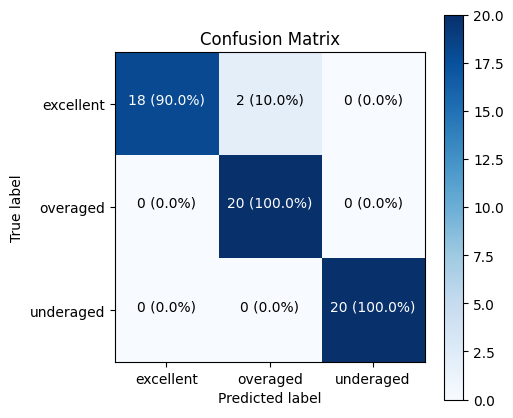

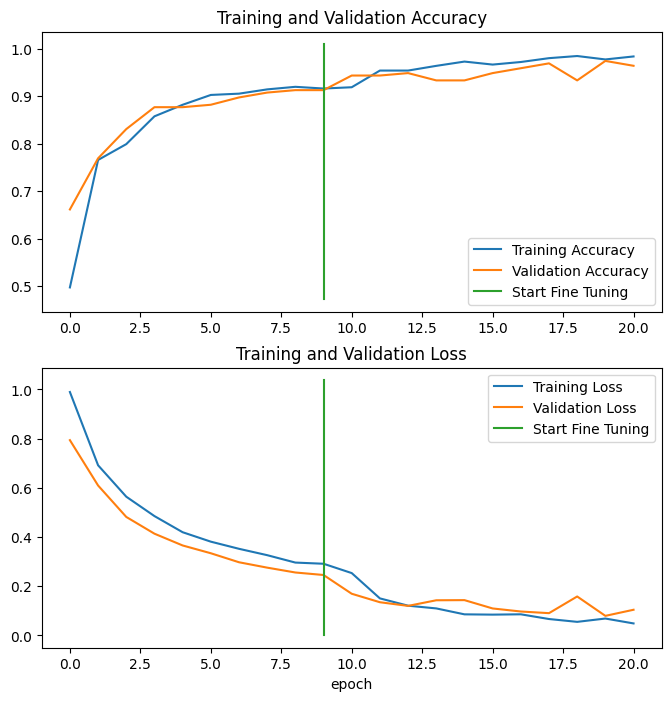

In [12]:
#Generate needed details
generate_details(model_2,test_data,[history2,history2_tuned,10],True)

Evaluating...
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step - accuracy: 0.9569 - loss: 0.0880
done.
Predicting...
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
done.
Close? True | Difference: -8.74201456779744e-08


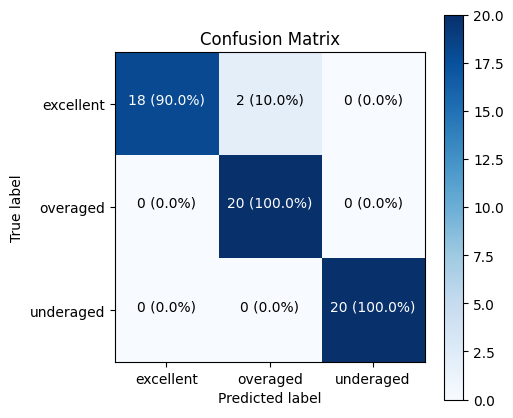

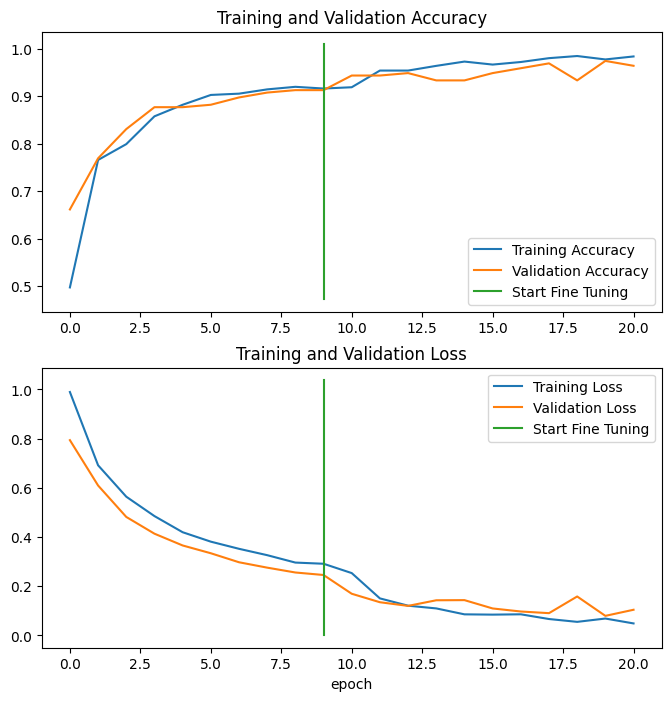

In [13]:
#Generate needed details
generate_details(model_2,test_data,[history2,history2_tuned,10],True)

# Model 3 ResNet50v2

In [14]:
base_model = tf.keras.applications.ResNet50V2(include_top=False)
base_model.trainable = False
inputs = tf.keras.layers.Input(shape=(224, 224, 3), name="input_layer")
x = layers.Rescaling(1./255,name="rescaler")(inputs)
x = base_model(x)
x = tf.keras.layers.GlobalAveragePooling2D(name="global_average_pooling_layer")(x)
x = tf.keras.layers.Dropout(0.2)(x)
outputs = tf.keras.layers.Dense(3, activation="softmax", name="output_layer")(x)
model_3 = tf.keras.Model(inputs, outputs)

model_3.compile(loss='categorical_crossentropy',
              optimizer=tf.keras.optimizers.Adam(),
              metrics=["accuracy"],
              jit_compile = False)

model_3.name = "Model_3_ResNet50v2"

(checkpoint_callback,checkpoint_path)=setup_checkpoint(model_3.name)

history3 = model_3.fit(train_data,
                       epochs=10,
                       validation_data=val_data,
                       callbacks=[checkpoint_callback]
                      )

Epoch 1/10
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step - accuracy: 0.3606 - loss: 1.4751
Epoch 1: val_loss improved from inf to 0.74704, saving model to checkpoints/Model_3_ResNet50v2.weights.h5
35/35 ━━━━━━━━━━━━━━━━━━━━ 11s 193ms/step - accuracy: 0.3628 - loss: 1.4695 - val_accuracy: 0.6513 - val_loss: 0.7470
Epoch 2/10
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step - accuracy: 0.6702 - loss: 0.8071
Epoch 2: val_loss improved from 0.74704 to 0.49431, saving model to checkpoints/Model_3_ResNet50v2.weights.h5
35/35 ━━━━━━━━━━━━━━━━━━━━ 5s 133ms/step - accuracy: 0.6708 - loss: 0.8055 - val_accuracy: 0.8256 - val_loss: 0.4943
Epoch 3/10
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step - accuracy: 0.7641 - loss: 0.5491
Epoch 3: val_loss improved from 0.49431 to 0.39456, saving model to checkpoints/Model_3_ResNet50v2.weights.h5
35/35 ━━━━━━━━━━━━━━━━━━━━ 5s 128ms/step - accuracy: 0.7646 - loss: 0.5484 - val_accuracy: 0.8667 - val_loss: 0.3946
Epoch 4/10
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step - accuracy: 0

## results

Evaluating...
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 701ms/step - accuracy: 0.9125 - loss: 0.1743
done.
Predicting...
2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 975ms/step
done.
Close? True | Difference: -2.384185793236071e-08


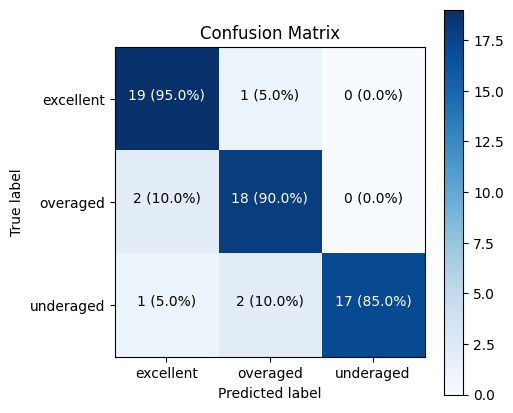

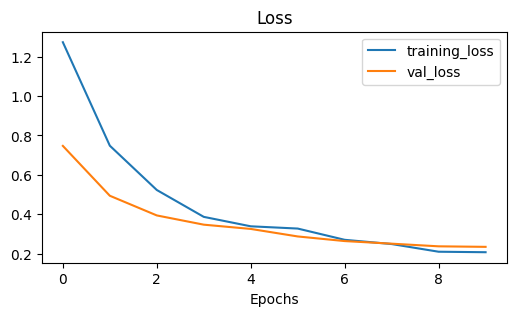

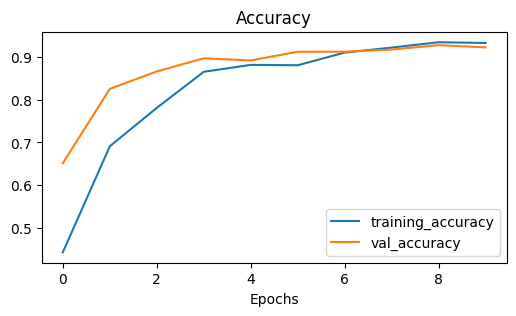

In [15]:
#Generate needed details
generate_details(model_3,test_data,[history3])

# Model 3 ResNet50v2 with fine-tuning

In [16]:
model_3.load_weights(checkpoint_path)
model_3.layers[2].trainable = False

for layer in model_3.layers[2].layers[-10:]:
    if not isinstance(layer, layers.BatchNormalization):
            layer.trainable = True

model_3.compile(loss='categorical_crossentropy',
              optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), #set lower training rate 0.001 is default
              metrics=["accuracy"],
              jit_compile = False)

model_3.name = "Model_3_ResNet50v2_with_fine-tuning"
(checkpoint_callback,checkpoint_path)=setup_checkpoint(model_3.name)

initial_epochs = 10
fine_tune_epochs = initial_epochs + 10
history3_tuned = model_3.fit(train_data,
                             epochs=fine_tune_epochs,
                             validation_data=val_data,
                             initial_epoch=history3.epoch[-1],
                             callbacks=[checkpoint_callback]
                            )

Epoch 10/20
35/35 ━━━━━━━━━━━━━━━━━━━━ 10s 163ms/step - accuracy: 0.8842 - loss: 0.3287 - val_accuracy: 0.9333 - val_loss: 0.1529
Epoch 11/20
35/35 ━━━━━━━━━━━━━━━━━━━━ 5s 128ms/step - accuracy: 0.9755 - loss: 0.0701 - val_accuracy: 0.9641 - val_loss: 0.1170
Epoch 12/20
35/35 ━━━━━━━━━━━━━━━━━━━━ 5s 133ms/step - accuracy: 0.9901 - loss: 0.0466 - val_accuracy: 0.9282 - val_loss: 0.1834
Epoch 13/20
35/35 ━━━━━━━━━━━━━━━━━━━━ 5s 140ms/step - accuracy: 0.9823 - loss: 0.0603 - val_accuracy: 0.9590 - val_loss: 0.0975
Epoch 14/20
35/35 ━━━━━━━━━━━━━━━━━━━━ 5s 136ms/step - accuracy: 0.9966 - loss: 0.0151 - val_accuracy: 0.9590 - val_loss: 0.1016
Epoch 15/20
35/35 ━━━━━━━━━━━━━━━━━━━━ 5s 129ms/step - accuracy: 0.9975 - loss: 0.0127 - val_accuracy: 0.9590 - val_loss: 0.1166
Epoch 16/20
35/35 ━━━━━━━━━━━━━━━━━━━━ 5s 127ms/step - accuracy: 0.9998 - loss: 0.0086 - val_accuracy: 0.9744 - val_loss: 0.0696
Epoch 17/20
35/35 ━━━━━━━━━━━━━━━━━━━━ 5s 132ms/step - accuracy: 0.9977 - loss: 0.0133 - val_acc

## results

Evaluating...
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step - accuracy: 0.9889 - loss: 0.0229
done.
Predicting...
2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 974ms/step
done.
Close? True | Difference: -4.371007278347605e-08


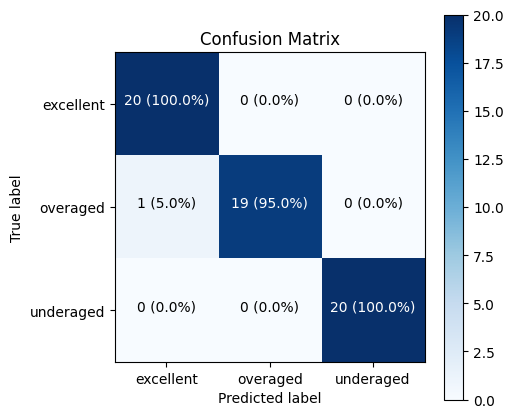

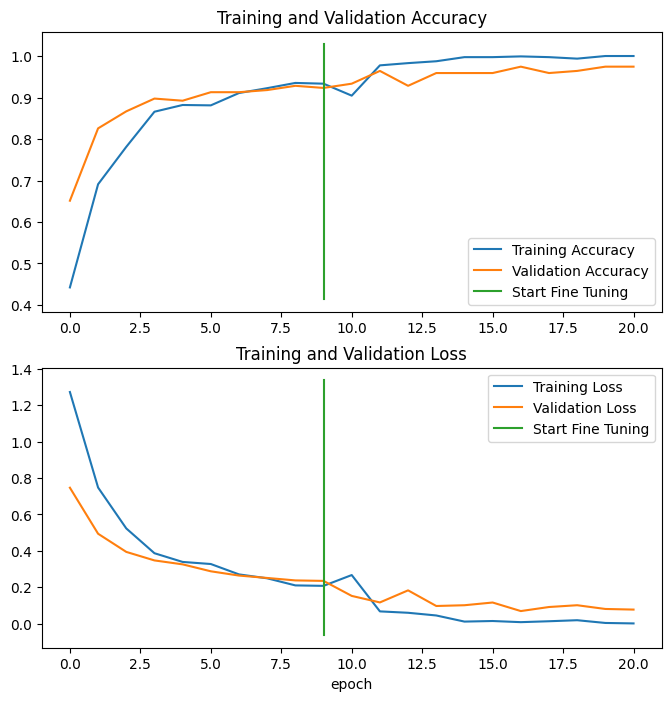

In [17]:
#Generate needed details
generate_details(model_3,test_data,[history3,history3_tuned,10],True)

# Model 4 ResNet50v2 with augmentation

In [18]:
data_augmentation = keras.Sequential([
  layers.RandomZoom(0.1,0.3),
  layers.RandomFlip("horizontal"),
], name ="data_augmentation")


input_shape = (224, 224, 3)
base_model = tf.keras.applications.ResNet50V2(include_top=False)
base_model.trainable = False
inputs = layers.Input(shape=input_shape, name="input_layer")

x = data_augmentation(inputs)
x = layers.Rescaling(1./255, name="rescaler")(x)
x = base_model(x)
x = layers.GlobalAveragePooling2D(name="global_average_pooling_layer")(x)
x = layers.Dropout(0.2)(x)
outputs = layers.Dense(3, activation="softmax", name="output_layer")(x)
model_4 = keras.Model(inputs, outputs)

model_4.compile(loss="categorical_crossentropy",
              optimizer=tf.keras.optimizers.Adam(),
              metrics=["accuracy"],
              jit_compile = False)

model_4.name = "Model_4_ResNet50v2_with_augmentation"

(checkpoint_callback,checkpoint_path)=setup_checkpoint(model_4.name)

history4 = model_4.fit(train_data,
                       epochs=10,
                       validation_data=val_data,
                       callbacks=[checkpoint_callback]
                      )

Epoch 1/10
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step - accuracy: 0.4215 - loss: 1.3073
Epoch 1: val_loss improved from inf to 0.92147, saving model to checkpoints/Model_4_ResNet50v2_with_augmentation.weights.h5
35/35 ━━━━━━━━━━━━━━━━━━━━ 11s 191ms/step - accuracy: 0.4234 - loss: 1.3030 - val_accuracy: 0.5692 - val_loss: 0.9215
Epoch 2/10
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step - accuracy: 0.6466 - loss: 0.7946
Epoch 2: val_loss improved from 0.92147 to 0.57144, saving model to checkpoints/Model_4_ResNet50v2_with_augmentation.weights.h5
35/35 ━━━━━━━━━━━━━━━━━━━━ 6s 165ms/step - accuracy: 0.6474 - loss: 0.7931 - val_accuracy: 0.7846 - val_loss: 0.5714
Epoch 3/10
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step - accuracy: 0.7391 - loss: 0.6509
Epoch 3: val_loss improved from 0.57144 to 0.45419, saving model to checkpoints/Model_4_ResNet50v2_with_augmentation.weights.h5
35/35 ━━━━━━━━━━━━━━━━━━━━ 6s 172ms/step - accuracy: 0.7396 - loss: 0.6496 - val_accuracy: 0.8462 - val_loss: 0.4542
Epoch 4/10

## results

Evaluating...
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step - accuracy: 0.9236 - loss: 0.2711
done.
Predicting...
2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 969ms/step
done.
Close? True | Difference: -3.973642981325298e-08


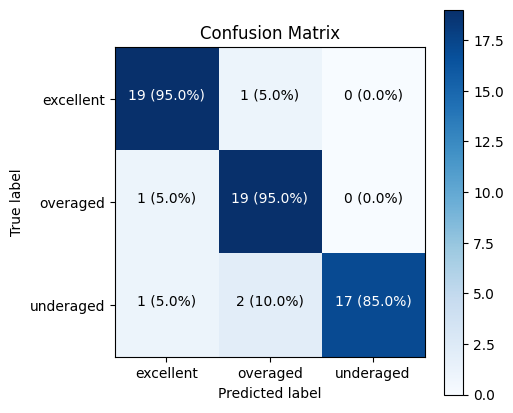

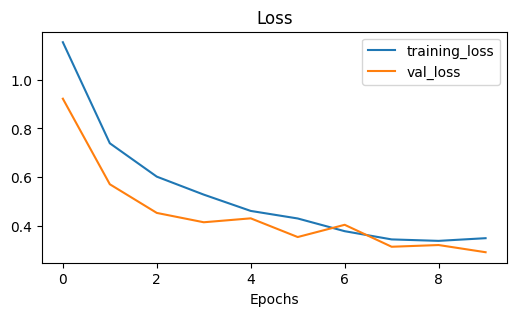

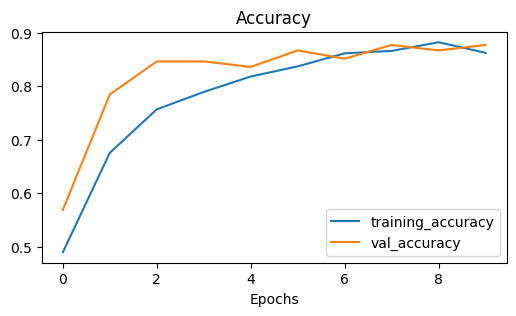

In [19]:
#Generate needed details
generate_details(model_4,test_data,[history4])

# Model 4 ResNet50v2 with augmentation with fine-tuning

In [20]:
model_4.load_weights(checkpoint_path)
model_4.layers[3].trainable = False

for layer in model_4.layers[3].layers[-10:]:
    if not isinstance(layer, layers.BatchNormalization):
            layer.trainable = True

model_4.compile(loss='categorical_crossentropy',
              optimizer=tf.keras.optimizers.Adam(learning_rate=0.00005), #set lower training rate
              metrics=["accuracy"],
              jit_compile = False)

model_4.name = "Model_4_ResNet50v2_with_augmentation_with_fine-tuning"
(checkpoint_callback,checkpoint_path)=setup_checkpoint(model_4.name)

initial_epochs = 10
fine_tune_epochs = initial_epochs + 10
history4_tuned = model_4.fit(train_data,
                             epochs=fine_tune_epochs,
                             validation_data=val_data,
                             initial_epoch=history4.epoch[-1],
                             callbacks=[checkpoint_callback]
                            )

Epoch 10/20
35/35 ━━━━━━━━━━━━━━━━━━━━ 11s 176ms/step - accuracy: 0.8550 - loss: 0.3730 - val_accuracy: 0.8769 - val_loss: 0.2590
Epoch 11/20
35/35 ━━━━━━━━━━━━━━━━━━━━ 6s 158ms/step - accuracy: 0.9105 - loss: 0.2137 - val_accuracy: 0.0000e+00 - val_loss: 0.2043
Epoch 12/20
35/35 ━━━━━━━━━━━━━━━━━━━━ 6s 156ms/step - accuracy: 0.9287 - loss: 0.1842 - val_accuracy: 0.8872 - val_loss: 0.2642
Epoch 13/20
35/35 ━━━━━━━━━━━━━━━━━━━━ 5s 152ms/step - accuracy: 0.9270 - loss: 0.1877 - val_accuracy: 0.9436 - val_loss: 0.1725
Epoch 14/20
35/35 ━━━━━━━━━━━━━━━━━━━━ 6s 155ms/step - accuracy: 0.9575 - loss: 0.1181 - val_accuracy: 0.9333 - val_loss: 0.1841
Epoch 15/20
35/35 ━━━━━━━━━━━━━━━━━━━━ 6s 164ms/step - accuracy: 0.9673 - loss: 0.1003 - val_accuracy: 0.9436 - val_loss: 0.1332
Epoch 16/20
35/35 ━━━━━━━━━━━━━━━━━━━━ 6s 160ms/step - accuracy: 0.9740 - loss: 0.0754 - val_accuracy: 0.9333 - val_loss: 0.2376
Epoch 17/20
35/35 ━━━━━━━━━━━━━━━━━━━━ 6s 165ms/step - accuracy: 0.9531 - loss: 0.1287 - val

## results

Evaluating...
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step - accuracy: 0.9556 - loss: 0.1103
done.
Predicting...
2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 963ms/step
done.
Close? True | Difference: -5.563100180516756e-08


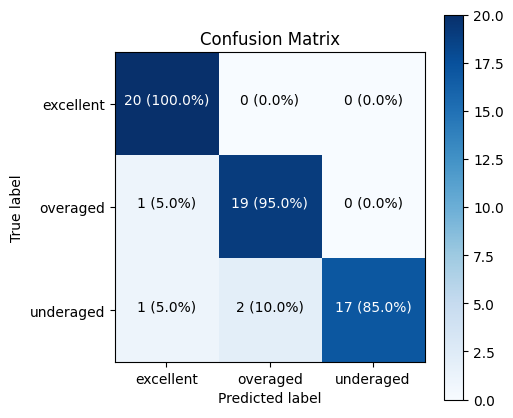

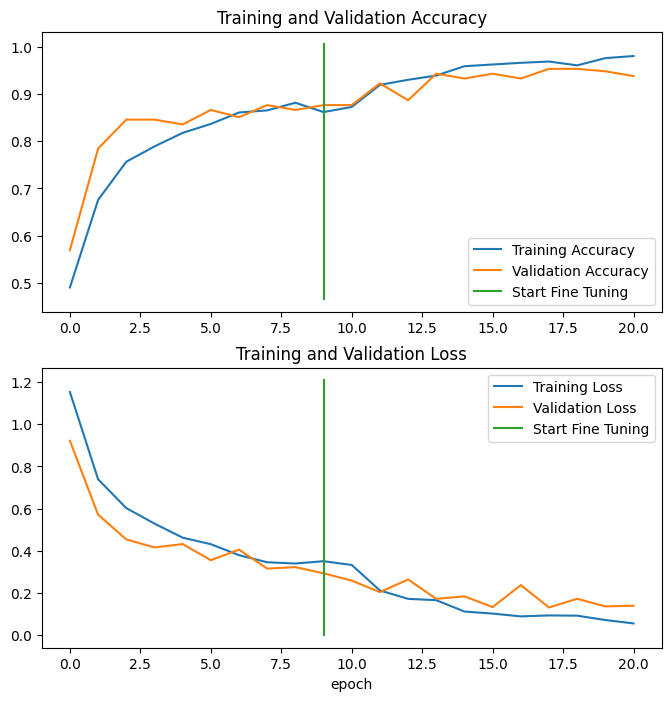

In [21]:
#Generate needed details
generate_details(model_4,test_data,[history4,history4_tuned,10],True)

# Model 5 VGG16

In [22]:
base_model = tf.keras.applications.VGG16(include_top=False)
base_model.trainable = False
inputs = layers.Input(shape=(224, 224, 3), name="input_layer")

x = layers.Rescaling(1./255)(inputs)

# 5. Pass the inputs to the base_model (note: using tf.keras.applications, EfficientNetV2 inputs don't have to be normalized)
x = base_model(x)
# 6. Average pool the outputs of the base model (aggregate all the most important information, reduce number of computations)
x = tf.keras.layers.GlobalAveragePooling2D(name="global_average_pooling_layer")(x)

# 7. Create the output activation layer
outputs = tf.keras.layers.Dense(3, activation="softmax", name="output_layer")(x)

# 8. Combine the inputs with the outputs into a model
model_5 = tf.keras.Model(inputs, outputs)

# 9. Compile the model
model_5.compile(loss='categorical_crossentropy',
              optimizer=tf.keras.optimizers.Adam(),
              metrics=["accuracy"],
              jit_compile = False)

model_5.name = "Model_5_VGG16"

(checkpoint_callback,checkpoint_path)=setup_checkpoint(model_5.name)

history5 = model_5.fit(train_data,
                       epochs=10,
                       validation_data=val_data,
                       callbacks=[checkpoint_callback]
                      )

Epoch 1/10
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step - accuracy: 0.3435 - loss: 1.1030
Epoch 1: val_loss improved from inf to 1.09194, saving model to checkpoints/Model_5_VGG16.weights.h5
35/35 ━━━━━━━━━━━━━━━━━━━━ 6s 150ms/step - accuracy: 0.3435 - loss: 1.1030 - val_accuracy: 0.3897 - val_loss: 1.0919
Epoch 2/10
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/step - accuracy: 0.4285 - loss: 1.0814
Epoch 2: val_loss improved from 1.09194 to 1.08117, saving model to checkpoints/Model_5_VGG16.weights.h5
35/35 ━━━━━━━━━━━━━━━━━━━━ 5s 130ms/step - accuracy: 0.4284 - loss: 1.0814 - val_accuracy: 0.3487 - val_loss: 1.0812
Epoch 3/10
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step - accuracy: 0.3902 - loss: 1.0732
Epoch 3: val_loss improved from 1.08117 to 1.06687, saving model to checkpoints/Model_5_VGG16.weights.h5
35/35 ━━━━━━━━━━━━━━━━━━━━ 5s 133ms/step - accuracy: 0.3912 - loss: 1.0730 - val_accuracy: 0.4718 - val_loss: 1.0669
Epoch 4/10
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step - accuracy: 0.4542 - loss: 1

## results

Evaluating...
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 318ms/step - accuracy: 0.5431 - loss: 0.9820
done.
Predicting...
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step
done.
Close? True | Difference: -3.1789143872806847e-08


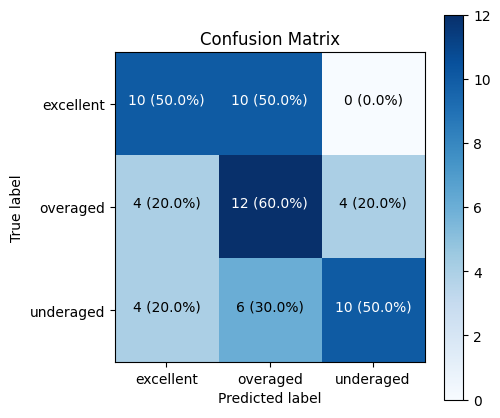

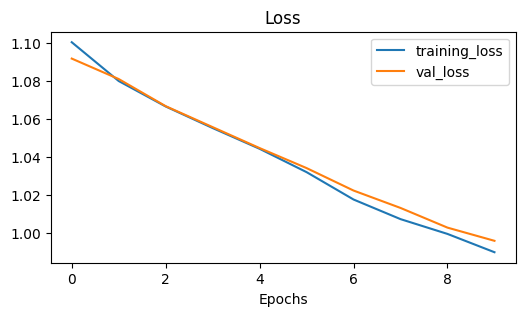

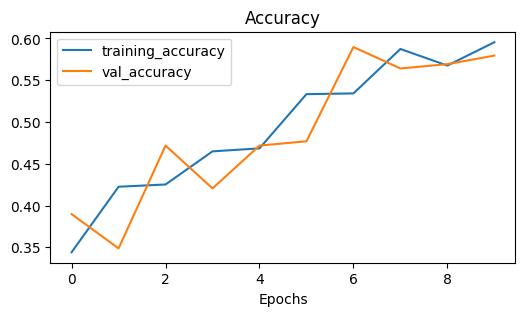

In [23]:
#Generate needed details
generate_details(model_5,test_data,[history5])

# Model 5 VGG16 with fine-tuning

In [24]:
model_5.load_weights(checkpoint_path)
model_5.layers[2].trainable = False

for layer in model_5.layers[2].layers[-10:]:
    if not isinstance(layer, layers.BatchNormalization):
            layer.trainable = True

model_5.compile(loss='categorical_crossentropy',
              optimizer=tf.keras.optimizers.Adam(learning_rate=0.00007), #set lower training rate 0.001 is default
              metrics=["accuracy"],
              jit_compile = False)

model_5.name = "Model_5_VGG16_with_fine-tuning"
(checkpoint_callback,checkpoint_path)=setup_checkpoint(model_5.name)

initial_epochs = 10
fine_tune_epochs = initial_epochs + 10
history5_tuned = model_5.fit(train_data,
                             epochs=fine_tune_epochs,
                             validation_data=val_data,
                             initial_epoch=history5.epoch[-1],
                             callbacks=[checkpoint_callback]
                            )

Epoch 10/20
35/35 ━━━━━━━━━━━━━━━━━━━━ 11s 246ms/step - accuracy: 0.3620 - loss: 1.1719 - val_accuracy: 0.4718 - val_loss: 1.0503
Epoch 11/20
35/35 ━━━━━━━━━━━━━━━━━━━━ 8s 219ms/step - accuracy: 0.5022 - loss: 0.9787 - val_accuracy: 0.7231 - val_loss: 0.7300
Epoch 12/20
35/35 ━━━━━━━━━━━━━━━━━━━━ 8s 216ms/step - accuracy: 0.7266 - loss: 0.6696 - val_accuracy: 0.8256 - val_loss: 0.6500
Epoch 13/20
35/35 ━━━━━━━━━━━━━━━━━━━━ 8s 215ms/step - accuracy: 0.7990 - loss: 0.5631 - val_accuracy: 0.8974 - val_loss: 0.2674
Epoch 14/20
35/35 ━━━━━━━━━━━━━━━━━━━━ 8s 215ms/step - accuracy: 0.9159 - loss: 0.2198 - val_accuracy: 0.9487 - val_loss: 0.1259
Epoch 15/20
35/35 ━━━━━━━━━━━━━━━━━━━━ 8s 218ms/step - accuracy: 0.9372 - loss: 0.1713 - val_accuracy: 0.9590 - val_loss: 0.1175
Epoch 16/20
35/35 ━━━━━━━━━━━━━━━━━━━━ 8s 218ms/step - accuracy: 0.9540 - loss: 0.1339 - val_accuracy: 0.8769 - val_loss: 0.4081
Epoch 17/20
35/35 ━━━━━━━━━━━━━━━━━━━━ 8s 220ms/step - accuracy: 0.9424 - loss: 0.1732 - val_acc

## results

Evaluating...
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step - accuracy: 0.9778 - loss: 0.1219
done.
Predicting...
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step
done.
Close? True | Difference: -8.74201456779744e-08


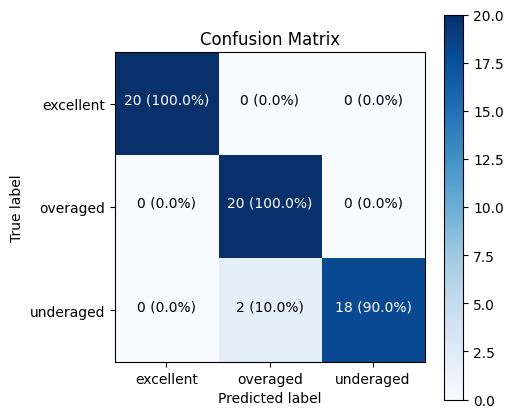

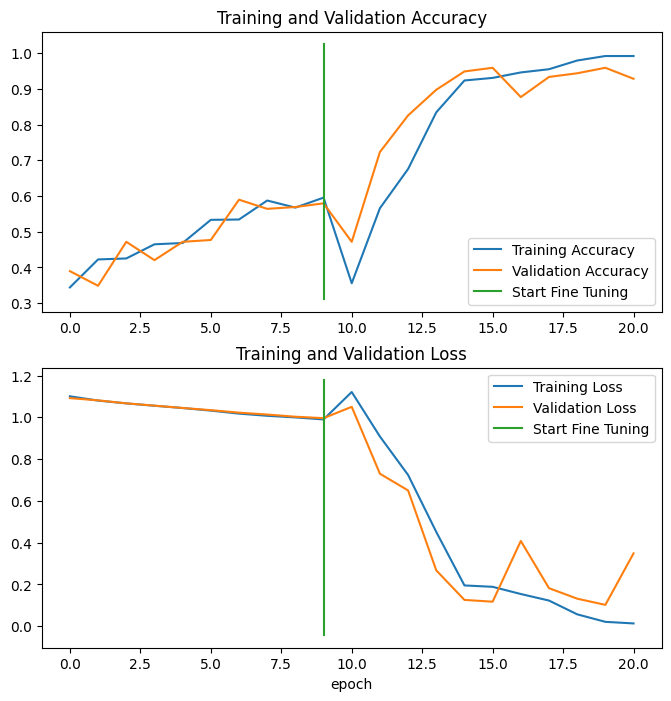

In [25]:
#Generate needed details
generate_details(model_5,test_data,[history5,history5_tuned,10],True)

# Model 6 VGG16 with augmentation

In [26]:
data_augmentation = keras.Sequential([
  layers.RandomZoom(0.1,0.3),
  layers.RandomFlip("horizontal"),
], name ="data_augmentation")

input_shape = (224, 224, 3)
base_model = tf.keras.applications.VGG16(include_top=False)
base_model.trainable = False
inputs = layers.Input(shape=input_shape, name="input_layer")
x = data_augmentation(inputs)
x = layers.Rescaling(1./255, name="rescaler")(x)
x = base_model(x)
x = layers.GlobalAveragePooling2D(name="global_average_pooling_layer")(x)
outputs = layers.Dense(3, activation="softmax", name="output_layer")(x)
model_6 = keras.Model(inputs, outputs)

model_6.compile(loss="categorical_crossentropy",
              optimizer=tf.keras.optimizers.Adam(),
              metrics=["accuracy"],
              jit_compile = False)

model_6.name = "Model_6_VGG16_with_augmentation"

(checkpoint_callback,checkpoint_path)=setup_checkpoint(model_6.name)

history6 = model_6.fit(train_data,
                       epochs=10,
                       validation_data=val_data,
                       callbacks=[checkpoint_callback]
                      )

Epoch 1/10
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step - accuracy: 0.3486 - loss: 1.1266
Epoch 1: val_loss improved from inf to 1.09362, saving model to checkpoints/Model_6_VGG16_with_augmentation.weights.h5
35/35 ━━━━━━━━━━━━━━━━━━━━ 7s 174ms/step - accuracy: 0.3488 - loss: 1.1261 - val_accuracy: 0.3179 - val_loss: 1.0936
Epoch 2/10
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step - accuracy: 0.3471 - loss: 1.0887
Epoch 2: val_loss improved from 1.09362 to 1.08247, saving model to checkpoints/Model_6_VGG16_with_augmentation.weights.h5
35/35 ━━━━━━━━━━━━━━━━━━━━ 6s 160ms/step - accuracy: 0.3468 - loss: 1.0889 - val_accuracy: 0.4718 - val_loss: 1.0825
Epoch 3/10
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step - accuracy: 0.4402 - loss: 1.0770
Epoch 3: val_loss improved from 1.08247 to 1.06963, saving model to checkpoints/Model_6_VGG16_with_augmentation.weights.h5
35/35 ━━━━━━━━━━━━━━━━━━━━ 6s 160ms/step - accuracy: 0.4403 - loss: 1.0770 - val_accuracy: 0.4154 - val_loss: 1.0696
Epoch 4/10
35/35 ━━━━━━━━━

## results

Evaluating...
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step - accuracy: 0.5431 - loss: 0.9819
done.
Predicting...
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step
done.
Close? True | Difference: -3.1789143872806847e-08


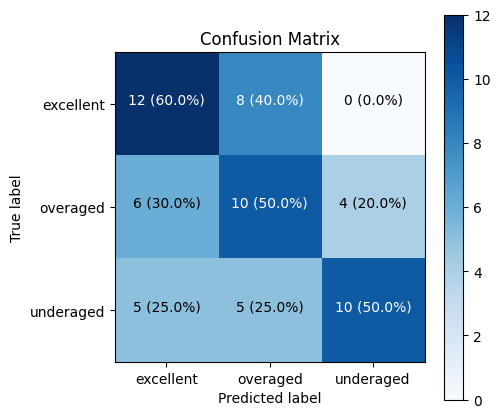

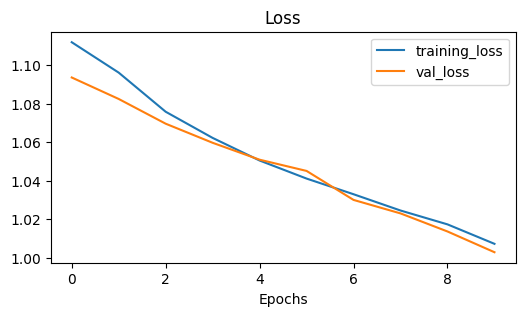

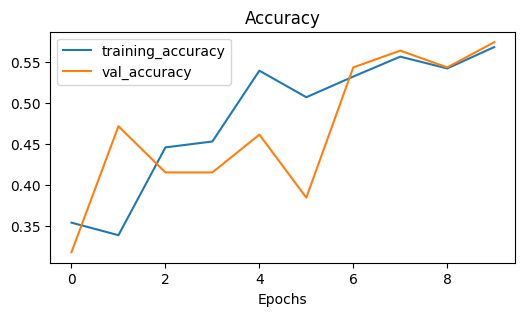

In [27]:
#Generate needed details
generate_details(model_6,test_data,[history6])

# Model 6 VGG16 with augmentation and fine-tuning

In [28]:
model_6.load_weights(checkpoint_path)
model_6.layers[3].trainable = False

for layer in model_6.layers[3].layers[-10:]:
    if not isinstance(layer, layers.BatchNormalization):
            layer.trainable = True

model_6.compile(loss='categorical_crossentropy',
              optimizer=tf.keras.optimizers.Adam(learning_rate=0.00007), #set lower training rate
              metrics=["accuracy"])

model_6.name = "Model_6_VGG16_with_augmentation_and_fine-tuningn"
(checkpoint_callback,checkpoint_path)=setup_checkpoint(model_6.name)

initial_epochs = 10
fine_tune_epochs = initial_epochs + 10
history6_tuned = model_6.fit(train_data,
                             epochs=fine_tune_epochs,
                             validation_data=val_data,
                             initial_epoch=history6.epoch[-1],
                             callbacks=[checkpoint_callback]
                            )

Epoch 10/20
35/35 ━━━━━━━━━━━━━━━━━━━━ 11s 262ms/step - accuracy: 0.4255 - loss: 1.1288 - val_accuracy: 0.6051 - val_loss: 0.8297
Epoch 11/20
35/35 ━━━━━━━━━━━━━━━━━━━━ 9s 256ms/step - accuracy: 0.6546 - loss: 0.6800 - val_accuracy: 0.8923 - val_loss: 0.3729
Epoch 12/20
35/35 ━━━━━━━━━━━━━━━━━━━━ 9s 253ms/step - accuracy: 0.8918 - loss: 0.3552 - val_accuracy: 0.9436 - val_loss: 0.1449
Epoch 13/20
35/35 ━━━━━━━━━━━━━━━━━━━━ 9s 255ms/step - accuracy: 0.9521 - loss: 0.1261 - val_accuracy: 0.9385 - val_loss: 0.1571
Epoch 14/20
35/35 ━━━━━━━━━━━━━━━━━━━━ 9s 256ms/step - accuracy: 0.9333 - loss: 0.1720 - val_accuracy: 0.9641 - val_loss: 0.0876
Epoch 15/20
35/35 ━━━━━━━━━━━━━━━━━━━━ 9s 259ms/step - accuracy: 0.9778 - loss: 0.0821 - val_accuracy: 0.9692 - val_loss: 0.0865
Epoch 16/20
35/35 ━━━━━━━━━━━━━━━━━━━━ 9s 256ms/step - accuracy: 0.9757 - loss: 0.0798 - val_accuracy: 0.0000e+00 - val_loss: 0.1448
Epoch 17/20
35/35 ━━━━━━━━━━━━━━━━━━━━ 9s 258ms/step - accuracy: 0.9310 - loss: 0.1517 - val

## results

Evaluating...
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step - accuracy: 0.9889 - loss: 0.0213
done.
Predicting...
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step
done.
Close? True | Difference: -4.371007278347605e-08


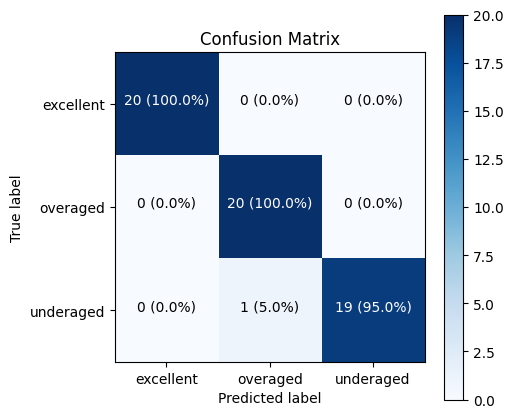

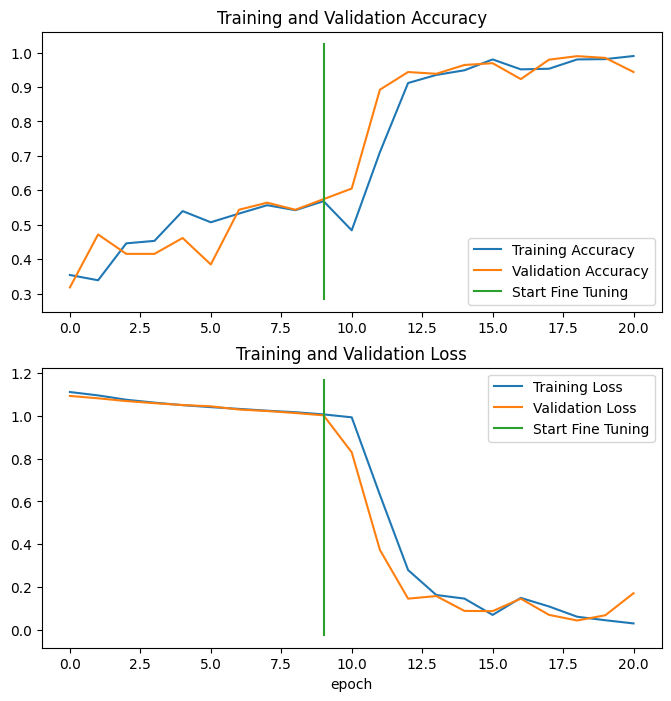

In [29]:
#Generate needed details
generate_details(model_6,test_data,[history6,history6_tuned,10],True)

# RESULT SUMMARY

In [30]:
show_results(res)

,Model,Loss,Accuracy
0,Model_1_EfficientNetB0,16.8524,100.0000
1,Model_1_EfficientNetB0_with_fine-tuning,2.4247,100.0000
2,Model_2_EfficientNetB0_with_augmentation,22.6666,95.0000
3,Model_2_EfficientNetB0_with_augmentation_and_f...,6.8793,96.6667
4,Model_2_EfficientNetB0_with_augmentation_and_f...,6.8793,96.6667
5,Model_3_ResNet50v2,19.4519,90.0000
6,Model_3_ResNet50v2_with_fine-tuning,2.7257,98.3333
7,Model_4_ResNet50v2_with_augmentation,29.2936,91.6667
8,Model_4_ResNet50v2_with_augmentation_with_fine...,14.6328,93.3333
9,Model_5_VGG16,97.3403,53.3333


In [36]:
show_results(res)

,Model,Loss,Accuracy
0,Model_1_EfficientNetB0,16.5069,98.3333
1,Model_1_EfficientNetB0_with_fine-tuning,6.1468,98.3333
2,Model_2_EfficientNetB0_with_augmentation,22.8676,93.3333
3,Model_2_EfficientNetB0_with_augmentation_and_f...,7.5851,98.3333
4,Model_3_ResNet50v2,20.5553,91.6667
5,Model_3_ResNet50v2_with_fine-tuning,4.3469,98.3333
6,Model_4_ResNet50v2_with_augmentation,32.0915,88.3333
7,Model_4_ResNet50v2_with_augmentation_with_fine...,42353.0792,45.0000
8,Model_5_VGG16,97.4988,50.0000
9,Model_5_VGG16_with_fine-tuning,9.8925,96.6667
